# Title I Allocations w/ DP ACS

## Algorithm

### Data
Need state per-pupil expenditure (SPPE) from the NCES. Most recent I can find in <5min is the [FY '18 data](https://nces.ed.gov/pubsearch/pubsinfo.asp?pubid=2020308).

Had to use an online tool to convert Table 2 of [this report](https://nces.ed.gov/pubs2020/2020308.pdf).

In [2]:
import pandas as pd

def get_sppe(path):
    states = { 'Alabama': 'AL', 'Alaska': 'AK', 'American Samoa': 'AS', 'Arizona': 'AZ', 'Arkansas': 'AR', 'California': 'CA', 'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE', 'District of Columbia': 'DC', 'Florida': 'FL', 'Georgia': 'GA', 'Guam': 'GU', 'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA', 'Kansas': 'KS', 'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD', 'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS', 'Missouri': 'MO', 'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV', 'New Hampshire': 'NH', 'New Jersey': 'NJ', 'New Mexico': 'NM', 'New York': 'NY', 'North Carolina': 'NC', 'North Dakota': 'ND', 'Northern Mariana Islands':'MP', 'Ohio': 'OH', 'Oklahoma': 'OK', 'Oregon': 'OR', 'Pennsylvania': 'PA', 'Puerto Rico': 'PR', 'Rhode Island': 'RI', 'South Carolina': 'SC', 'South Dakota': 'SD', 'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT', 'Vermont': 'VT', 'Virgin Islands': 'VI', 'Virginia': 'VA', 'Washington': 'WA', 'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY' }
    states = pd.DataFrame(states.items(), columns=["state", "abbrv"])
    
    # quirk of original data file - need to change DC's name for join
    states[states.state == "District of Columbia"] = "District Of Columbia Public Schools"

    sppe = pd.read_excel(path, header=2).rename(columns={"Unnamed: 0": "state"})[["state", "ppe"]]

    return sppe.merge(states, on="state", how="right")

sppe = get_sppe("../data/sppe18.xlsx")
sppe.head()

,state,ppe,abbrv
0,Alabama,9697,AL
1,Alaska,17726,AK
2,American Samoa,NaN,AS
3,Arizona,8296,AZ
4,Arkansas,10072,AR


Also need a dict matching district IDs to district names to states. Simplest to use [SAIPE 2019](https://www2.census.gov/programs-surveys/saipe/datasets/2019/2019-school-districts/) ground-truth.

In [3]:
saipe = pd.read_excel("../data/saipe19.xls", header=2).set_index("District ID")
saipe.head()

,State Postal Code,State FIPS Code,Name,Estimated Total Population,Estimated Population 5-17,Estimated number of relevant children 5 to 17 years old in poverty who are related to the householder
District ID,,,,,,
190,AL,1,Alabaster City School District,34669,6710,649
5,AL,1,Albertville City School District,22051,4131,957
30,AL,1,Alexander City City School District,16920,2575,703
60,AL,1,Andalusia City School District,8842,1465,406
90,AL,1,Anniston City School District,22043,3065,1057


### Code

In [5]:
from typing import Tuple

class Mechanism:
    def __init__(self, epsilon, delta):
        self.epsilon = epsilon
        self.delta = delta
        
    def poverty_estimates(self) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
        """
        Returns dataframe for children in poverty, children total, and total population indexed by district ID.
        """
        raise NotImplementedError
        
class GroundTruth(Mechanism):
    """
    example mech that just returns the ground truth SAIPE estimates
    """
    def __init__(self, saipe):
        self.saipe = saipe
        
    def poverty_estimates(self):
        return (self.saipe[key] for key in ["Estimated Total Population", "Estimated Population 5-17", "Estimated number of relevant children 5 to 17 years old in poverty who are related to the householder"])

In [6]:
from math import floor, ceil

def weighting(eligible, pop):
    """
    Gradated weighting algorithm given in [Sonnenberg](https://nces.ed.gov/surveys/annualreports/pdf/titlei20160111.pdf).
    
    Returns weighted eligibility counts.
    """
    
    # calculate weighted count based on counts
    wec_counts = 0
    for r, w in {(1, 691): 1.0, (692, 2262): 1.5, (2263,7851): 2.0, (7852, 35514): 2.5, (35514, None): 3.0}.items():
        if r[1] is not None and eligible > r[1]: 
            wec_counts += (r[1] - r[0] + 1) * w
        elif eligible >= r[0]: 
            wec_counts += (eligible - r[0] + 1) * w
    
    # calculate weighted count based on proportions
    wec_props = 0
    for r, w in {(0, 0.1558): 1.0, (0.1558, 0.2211): 1.75, (0.2211,0.3016): 2.5, (0.3016, 0.3824): 3.25, (0.3824, None): 4.0}.items():
        upper = floor(r[1]*pop) if r[1] is not None else None
        lower = ceil(r[0]*pop)
        
        if upper is not None and eligible > upper: 
            wec_props += (upper - lower) * w
        elif eligible >= lower: 
            wec_props += (eligible - lower) * w
    
    # take the higher weighted eligibility count
    return max(wec_counts, wec_props)
    
weighting(1559, 10000)

1993.0

[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']


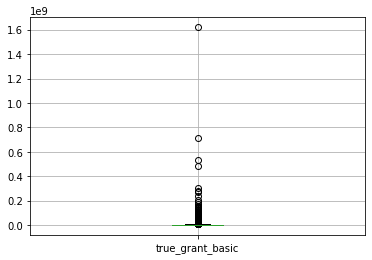

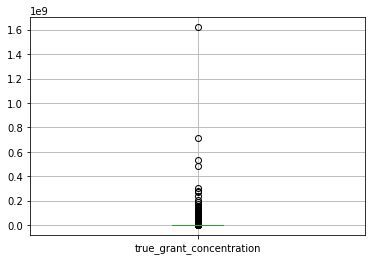

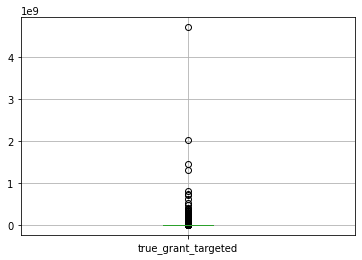

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def funding(saipe, mechanism, sppe, weighting, adj_sppe_bounds=[0.32, 0.48], adj_sppe_bounds_efig=[0.34, 0.46], congress_cap=0.4, *mech_args, verbose=True, **mech_kwargs):
    """
    congress_cap - proportion of a student's edu congress agrees to fund
    
    Returns augmented SAIPE dataframe with randomized estimates and true/randomized grant amounts.
    """
    grants = saipe.rename(columns={
        "Estimated Total Population": "true_pop_total",
        "Estimated Population 5-17": "true_children_total",
        "Estimated number of relevant children 5 to 17 years old in poverty who are related to the householder": "true_children_poverty"
    })
    pop_total, children_total, children_poverty = mechanism.poverty_estimates(*mech_args, **mech_kwargs)
    grants["est_pop_total"] = pop_total
    grants["est_children_total"] = children_total
    grants["est_children_poverty"] = children_poverty

    # BIG ASSUMPTION, TODO: revisit later
    grants["true_children_eligible"] = grants.true_children_poverty
    grants["est_children_eligible"] = grants.est_children_poverty
    
    # join in SPPE
    grants = grants.merge(sppe, left_on="State Postal Code", right_on="abbrv").drop(columns=['abbrv', 'state']).rename(columns={'ppe': 'sppe'})
    if verbose: print("[WARN] Dropping districts with missing SPPE data:", grants[grants.sppe.isna()]['Name'].values)
    grants = grants.dropna(subset=["sppe"])
    grants.sppe = grants.sppe.astype(float)
    
    # calculate grant amounts for true/randomized values
    for prefix in ("true", "est"):        
        # calculate adjusted SPPE
        avg_sppe = np.mean(grants.sppe)
        adj_sppe = grants.sppe * congress_cap
        adj_sppe_trunc = adj_sppe.clip(*np.array(adj_sppe_bounds)*avg_sppe)
        adj_sppe_efig = adj_sppe.clip(*np.array(adj_sppe_bounds_efig)*avg_sppe)
#         # double check calc
#         print(np.array(adj_sppe_bounds)*avg_sppe)
#         print(min(adj_sppe_trunc), max(adj_sppe_trunc))
            
        ## BASIC GRANTS
        # authorization calculation
        grants[f"{prefix}_grant_basic"] = grants[f"{prefix}_children_eligible"] * adj_sppe_trunc
        # For basic grants, LEA must have >10 eligible children
        eligible = grants[f"{prefix}_children_eligible"] >= 10
#         print(sum(~eligible)/eligible.shape[0])
        grants.loc[~eligible, f"{prefix}_grant_basic"] = 0.0
        
        ## CONCENTRATION GRANTS
        # For concentration grants, LEAs must meet basic eligibility AND have either
        # a) >6500 eligible
        # b) 15% of pop. is eligible
        grants[f"{prefix}_grant_concentration"] = grants[f"{prefix}_grant_basic"]
        count_eligible = grants[f"{prefix}_children_eligible"] >= 6500
        prop_eligible = (grants[f"{prefix}_children_eligible"] / grants[f"{prefix}_children_total"]) >= 0.15
        eligible = count_eligible | prop_eligible
#         print(sum(~eligible)/eligible.shape[0])
        grants.loc[~eligible, f"{prefix}_grant_concentration"] = 0.0
        
        ## TARGETED GRANTS
        # weighted by an exogenous step function - see documentation
        weighted_eligible = grants[[f"{prefix}_children_eligible", f"{prefix}_children_total"]].apply(
            lambda x: weighting(x[0], x[1])
        , axis=1)
        grants[f"{prefix}_grant_targeted"] = weighted_eligible * adj_sppe_trunc
        
        # for targeted grants, LEAs must meet basic eligibility AND have >5% eligible
        count_eligible = grants[f"{prefix}_children_eligible"] >= 10
        prop_eligible = (grants[f"{prefix}_children_eligible"] / grants[f"{prefix}_children_total"]) >= 0.05
        eligible = count_eligible & prop_eligible
        grants.loc[~eligible, f"{prefix}_grant_targeted"] = 0.0
        
        ## EFIG
        # TODO
        
    
    # TODO - calculate *allocation* amounts
    return grants


# Test with ground truth mechanism
grants = funding(saipe, GroundTruth(saipe), get_sppe("../data/sppe18.xlsx"), weighting)
grants.boxplot('true_grant_basic')
plt.show()
grants.boxplot('true_grant_concentration')
plt.show()
grants.boxplot('true_grant_targeted')
plt.show()

## Laplace
### Data
From [SAIPE 2019](https://www2.census.gov/programs-surveys/saipe/datasets/2019/2019-school-districts/) release.

### Mechanism

In [61]:
from diffprivlib.mechanisms.laplace import Laplace as LaplaceMech, LaplaceTruncated

"""
Following Abowd & Schmutte (2019), return \hat{E}_l = E_l + e_l, where e_l \sim Laplace(1/\epsilon). 

Recall that the sensitivity of the counts here is simply 1.
"""

class Laplace(Mechanism):
    def __init__(self, saipe, *args, pos_trunc=False, **kwargs):
        super().__init__(*args, **kwargs)
        self.saipe = saipe
        
        self.mechanism = \
            LaplaceTruncated(epsilon=self.epsilon, delta=self.delta, sensitivity=1.0, lower=0.0) if pos_trunc \
            else LaplaceMech(epsilon=self.epsilon, delta=self.delta, sensitivity=1.0)
        
    def poverty_estimates(self) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
        
        pop_total = saipe["Estimated Total Population"].apply(self.mechanism.randomise)
        children_total = saipe["Estimated Population 5-17"].apply(self.mechanism.randomise)
        children_poverty = saipe["Estimated number of relevant children 5 to 17 years old in poverty who are related to the householder"].apply(self.mechanism.randomise)
        
        # no negative values, please
        return np.clip(pop_total, 0, None), np.clip(children_total, 0, None), np.clip(children_poverty, 0, None)
        
Laplace(saipe, 0.1, 0).poverty_estimates()

(District ID
 190     3.467366e+04
 5       2.204312e+04
 30      1.692259e+04
 60      8.831540e+03
 90      2.207187e+04
             ...     
 6240    7.122699e+03
 5820    6.793398e+02
 4830    5.474434e+03
 6090    1.458011e+03
 30      3.193703e+06
 Name: Estimated Total Population, Length: 13184, dtype: float64,
 District ID
 190       6721.494930
 5         4126.104240
 30        2592.999402
 60        1456.179968
 90        3078.521349
             ...      
 6240      1295.738606
 5820        80.678464
 4830       806.591716
 6090       260.072384
 30      455244.709906
 Name: Estimated Population 5-17, Length: 13184, dtype: float64,
 District ID
 190        648.383454
 5          930.877809
 30         704.537766
 60         390.978721
 90        1045.354056
             ...      
 6240       158.143161
 5820         6.442730
 4830       124.458004
 6090        18.633169
 30      248614.287769
 Name: Estimated number of relevant children 5 to 17 years old in poverty who are 

### Testing

In [62]:
grants = funding(saipe, Laplace(saipe, 5, 0), get_sppe("../data/sppe18.xlsx"), weighting)
grants.describe()

[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']


,State FIPS Code,true_pop_total,true_children_total,true_children_poverty,est_pop_total,est_children_total,est_children_poverty,true_children_eligible,est_children_eligible,sppe,true_grant_basic,true_grant_concentration,true_grant_targeted,est_grant_basic,est_grant_concentration,est_grant_targeted
count,13182.000000,1.318200e+04,1.318200e+04,13182.000000,1.318200e+04,1.318200e+04,13182.000000,13182.000000,13182.000000,13182.000000,1.318200e+04,1.318200e+04,1.318200e+04,1.318200e+04,1.318200e+04,1.318200e+04
mean,29.561751,2.651938e+04,4.049290e+03,625.253224,2.651938e+04,4.049293e+03,625.252624,625.253224,625.252624,13027.845092,3.026463e+06,2.231939e+06,5.062192e+06,3.026324e+06,2.231738e+06,5.061973e+06
std,14.644764,1.155746e+05,1.728792e+04,3467.140325,1.155746e+05,1.728792e+04,3467.138837,3467.140325,3467.138837,3667.794832,1.912444e+07,1.908713e+07,5.239813e+07,1.912446e+07,1.908713e+07,5.239814e+07
min,1.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,7525.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,18.000000,2.802000e+03,4.260000e+02,52.000000,2.801749e+03,4.260738e+02,52.090521,52.000000,52.090521,10157.000000,2.617935e+05,0.000000e+00,1.924048e+05,2.608340e+05,0.000000e+00,1.924473e+05
50%,30.000000,7.911000e+03,1.186000e+03,147.000000,7.911034e+03,1.186182e+03,147.237746,147.000000,147.237746,12159.000000,7.504039e+05,0.000000e+00,7.283281e+05,7.500140e+05,0.000000e+00,7.291623e+05
75%,40.000000,2.101825e+04,3.222000e+03,411.000000,2.101824e+04,3.222037e+03,411.101549,411.000000,411.101549,15780.000000,2.076117e+06,9.130432e+05,2.294255e+06,2.076103e+06,9.143434e+05,2.293170e+06
max,56.000000,8.336817e+06,1.193045e+06,259012.000000,8.336817e+06,1.193045e+06,259011.856315,259012.000000,259011.856315,22845.000000,1.619697e+09,1.619697e+09,4.714287e+09,1.619696e+09,1.619696e+09,4.714285e+09


In [63]:
# rmse basic
eps = list(np.logspace(-3, 1)) + [2.5]
allocations = []
for e in eps:
    print(e, end=" ")
    allocations.append(funding(saipe, Laplace(saipe, e, 0), get_sppe("../data/sppe18.xlsx"), weighting, verbose=False))

0.001 0.0012067926406393288 0.0014563484775012444 0.0017575106248547913 0.0021209508879201904 0.002559547922699536 0.0030888435964774815 0.003727593720314938 0.004498432668969444 0.005428675439323859 0.006551285568595509 0.0079060432109077 0.009540954763499945 0.01151395399326447 0.013894954943731374 0.016768329368110076 0.020235896477251564 0.02442053094548651 0.029470517025518096 0.03556480306223129 0.04291934260128776 0.0517947467923121 0.0625055192527397 0.07543120063354615 0.09102981779915217 0.10985411419875583 0.13257113655901082 0.15998587196060574 0.19306977288832497 0.2329951810515372 0.2811768697974228 0.3393221771895326 0.4094915062380423 0.49417133613238334 0.5963623316594643 0.7196856730011514 0.868511373751352 1.0481131341546852 1.2648552168552958 1.5264179671752318 1.8420699693267144 2.2229964825261934 2.6826957952797246 3.2374575428176433 3.906939937054613 4.714866363457389 5.689866029018293 6.866488450042998 8.286427728546842 10.0 2.5 

## basic grants ##
RMSE at eps=2.5: 4236.386478689903
Total misalloc at eps=2.5: 28061226.528207935
Total true alloc: 39894838662.272514


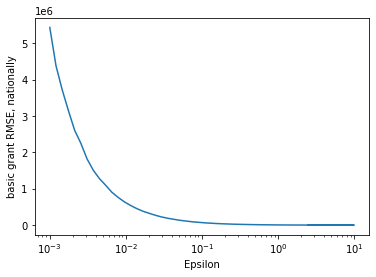

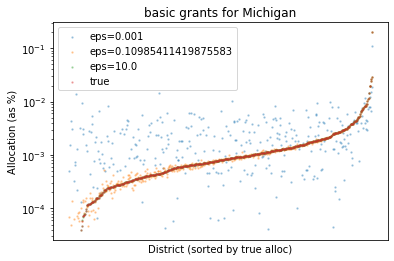

<ipython-input-80-4b17b394885b>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alloc['err_prop'] = (alloc[f"est_grant_{grant_type}"]/sum(alloc[f"est_grant_{grant_type}"]) - alloc[f"true_grant_{grant_type}"]/sum(alloc[f"true_grant_{grant_type}"])) * 1e6


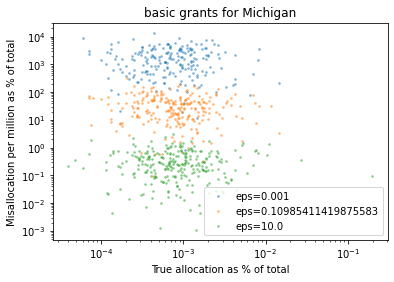

## concentration grants ##
RMSE at eps=2.5: 44174.194413913974
Total misalloc at eps=2.5: 28840214.727422163
Total true alloc: 29421416873.03583


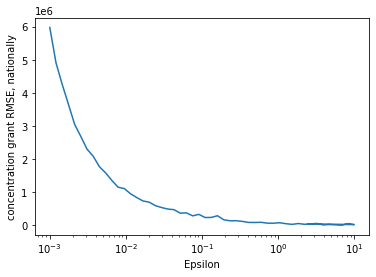

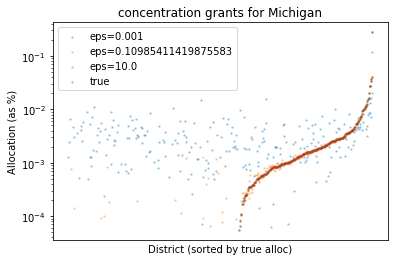

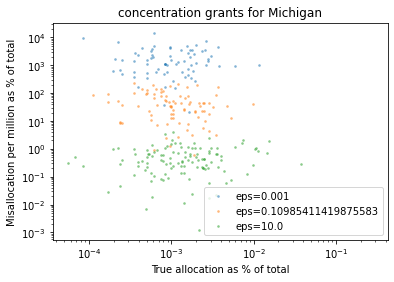

## targeted grants ##
RMSE at eps=2.5: 11642.605239515728
Total misalloc at eps=2.5: 42660000.71207756
Total true alloc: 66729811774.698265


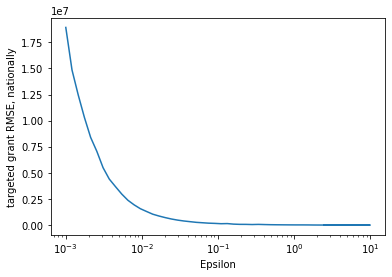

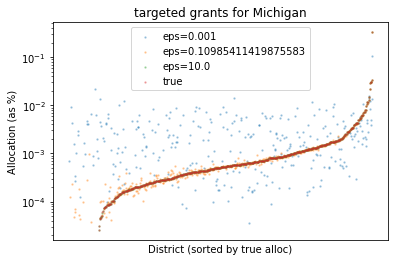

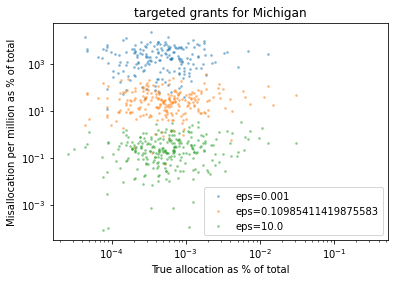

In [80]:
for grant_type in ("basic", "concentration", "targeted"):
    print(f"## {grant_type} grants ##")
    mse = []
    for alloc, e in zip(allocations, eps):
        error = alloc[f"true_grant_{grant_type}"]-alloc[f"est_grant_{grant_type}"]
        mse.append(np.sqrt(sum(error**2)/alloc.shape[0]))
        if (e == 2.5):
            print("RMSE at eps=2.5:", np.sqrt(sum(error**2)/alloc.shape[0]))
            print("Total misalloc at eps=2.5:", sum(abs(error)))
            print("Total true alloc:", sum(alloc[f"true_grant_{grant_type}"]))

    plt.plot(eps, mse)
    ax = plt.gca()
    ax.set_xscale('log')
    plt.xlabel("Epsilon")
    plt.ylabel(f"{grant_type} grant RMSE, nationally")
    plt.show()
    
    for i in [0, 25, -2]:
        e = eps[i]
        alloc = allocations[i][allocations[i]["State Postal Code"] == "MI"]
        alloc = alloc.sort_values(f"true_grant_{grant_type}")
        plt.scatter(alloc.index.astype('str'), alloc[f"est_grant_{grant_type}"]/sum(alloc[f"est_grant_{grant_type}"]), s=2, alpha=0.3, label=f"eps={e}")
    plt.scatter(alloc.index.astype('str'), alloc[f"true_grant_{grant_type}"]/sum(alloc[f"true_grant_{grant_type}"]), s=2, alpha=0.3, label="true")
    ax = plt.gca()
    ax.legend()
    ax.axes.xaxis.set_ticks([])
    ax.set_yscale('log')
    plt.xlabel("District (sorted by true alloc)")
    plt.ylabel("Allocation (as %)")
    plt.title(f"{grant_type} grants for Michigan")
    plt.show()
    
    for i in [0, 25, -2]:
        e = eps[i]
        alloc = allocations[i][allocations[i]["State Postal Code"] == "MI"]
        alloc['err_prop'] = (alloc[f"est_grant_{grant_type}"]/sum(alloc[f"est_grant_{grant_type}"]) - alloc[f"true_grant_{grant_type}"]/sum(alloc[f"true_grant_{grant_type}"])) * 1e6
        plt.scatter(alloc[f"true_grant_{grant_type}"]/sum(alloc[f"true_grant_{grant_type}"]), alloc.err_prop, s=3, alpha=0.4, label=f"eps={e}")
    ax = plt.gca()
    ax.legend()
    ax.set_xscale('log')
    ax.set_yscale('log')
    plt.xlabel("True allocation as % of total")
    plt.ylabel("Misallocation per million as % of total")
    plt.title(f"{grant_type} grants for Michigan")
    plt.show()